시작

In [15]:

import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import seaborn as sns #시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import calendar 
from datetime import datetime

import os
print(os.listdir("./input"))

['sampleSubmission.csv', 'test.csv', 'train.csv']


In [16]:
#훈련데이터와 테스트 데이터 세트를 불러온다
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

In [17]:
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])
# datetime을 년,월,일,시 값으로 나누어서 확인
train['year'] = train.datetime.dt.year
train['month'] = train.datetime.dt.month
train['day'] = train.datetime.dt.day
train['hour'] = train.datetime.dt.hour
train['dayofweek'] = train.datetime.dt.dayofweek

test['year'] = test.datetime.dt.year
test['month'] =test.datetime.dt.month
test['day'] = test.datetime.dt.day
test['hour'] = test.datetime.dt.hour
test['dayofweek'] = test.datetime.dt.dayofweek

In [18]:
# 필요 없는 특성 제거
train.columns, test.columns
del_train=['datetime','casual','registered']
train.drop(del_train, axis=1,inplace=True)
test.drop('datetime', axis=1,inplace=True)

추가로 필요 없는 특성을 찾기 위해 이것저것 지워보자

windspeed == 0 를 평균값으로 대체

In [24]:
train.loc[train['windspeed']==0,'windspeed'] = train['windspeed'].mean()

최종 tarin, test 값

In [25]:
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,dayofweek
0,1,0,0,1,9.84,14.395,81,12.799395,16,2011,1,1,0,5
1,1,0,0,1,9.02,13.635,80,12.799395,40,2011,1,1,1,5
2,1,0,0,1,9.02,13.635,80,12.799395,32,2011,1,1,2,5
3,1,0,0,1,9.84,14.395,75,12.799395,13,2011,1,1,3,5
4,1,0,0,1,9.84,14.395,75,12.799395,1,2011,1,1,4,5


In [26]:
test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,dayofweek
0,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0,3
1,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1,3
2,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2,3
3,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,3
4,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4,3


모델 평가

In [27]:
# y is predict value y_ is actual value
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y), 
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [28]:
from sklearn.model_selection import train_test_split
target = train['count']
features = train.drop(columns=['count'])
train_input, test_input, train_target, test_target = train_test_split(
    features,target, random_state=42
)

train_target_log = np.log1p(train_target)
test_target_log = np.log1p(test_target)

선형회귀

In [29]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
lr = LinearRegression()

lr.fit(train_input,train_target_log)
print(lr.score(train_input,train_target_log))
print(lr.score(test_input,test_target_log))
# 성능평가
pred = lr.predict(test_input)
print('RMSLE Value for LinearRegression {}'.format(rmsle(np.exp(test_target_log),np.exp(pred),False)))

0.48996419639959776
0.4798423744376987
RMSLE Value for LinearRegression 0.9828508106684792


In [30]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor()

gb.fit(train_input,train_target_log)
print(gb.score(train_input,train_target_log))
print(gb.score(test_input,test_target_log))
preds = gb.predict(train_input)
print('RMSLE Value for GradientBoosting {}'.format(rmsle(np.exp(train_target_log),np.exp(preds),False)))

0.9294737840293372
0.9257839466518053
RMSLE Value for GradientBoosting 0.35968926817971497


In [31]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

rf.fit(train_input,train_target_log)
print(rf.score(train_input,train_target_log))
print(rf.score(test_input,test_target_log))
preds = rf.predict(test_input)
print('RMSLE Value for RandomForest {}'.format(rmsle(np.exp(test_target_log),np.exp(preds),False)))

0.9935159280938427
0.9567251421946473
RMSLE Value for RandomForest 0.27692714961683007


In [32]:
# RandomForestRegressor
preds_rf = rf.predict(test)
# 다시 지수로 바꾸기
test_target_exp = np.exp(test_target_log)
preds_rf_exp = np.exp(preds_rf)
# evaluate_regr(test_target_exp,pred_exp)

preds_rf_exp

array([ 14.74308551,   7.1319821 ,   4.82242457, ..., 130.030709  ,
       106.60668732,  63.14688987])

<AxesSubplot:ylabel='Density'>

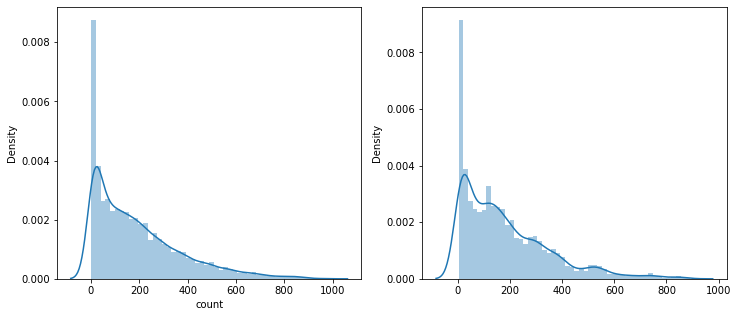

In [33]:
predsTest = rf.predict(test)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(target,ax=ax1,bins=50)
sns.distplot(preds_rf_exp,ax=ax2,bins=50)

In [35]:
submit = pd.read_csv("./input/sampleSubmission.csv")
submit['count'] = preds_rf_exp
submit.to_csv("./results_rf_1.3.csv",index=False)

1.0v 다른점
windspeed == 0 을 windspeed.mean()으로 바꿈




0.44727 더 안 좋아 졌다.